# Network Analysis Using Reinforcement Learning
## Spring 2022: Shaoyu Pei, Avery Peiffer

## Advisor: Dr. Mai Abdelhakim

## Notebook 2: Applying Reinforcement Learning to the Problem
If you have not already read through and tested out the network setup, please take some time to do so. It will provide you with the necessary background to understand the problem.

The purpose of this notebook is to implement a reinforcement learning algorithm using our network environment code. This allows us to train reinforcement learning algorithms. We modified [Laura D'Arcy's GraphRLnx repository](https://github.com/lauradarcy/graphRLnx) to create this class.

Please refer to the `tutorials/` folder for an overview of reinforcement learning and Q-learning. Essentially, we wish for our algorithm to learn the most trustworthy path(s) from the source to the destination. A trustworthy path is one that is unlikely to be corrupted from past examples. We start by sending packets through the network randomly; we then use a function to see if the transmission was 'corrupted' in the way that we have previously defined it. We also take into consideration the number of hops the path takes. We adjust our incentive structure accordingly and, over time, the algorithm will learn what paths are optimal.

Our model makes the assumption that there is one reinforcement learning controller that is overseeing the entire process. Additionally, we wish to acknowledge the action and state spaces that make up our reinforcement learning space. The state space represents the possible list of states that the algorithm can take in a given time step. In this case, it is defined as the possible nodes that can be visited along a path from the source to destination node. Likewise, the action space represents the possible actions that can be taken from the given state. For this model, the action space is defined as the nodes that are neighboring the current node and that have not already been visited along the current path (this helps avoid cycles and infinite loops).

**Note:** If you get any errors due to packages not being installed, please add them to the cell below. We might have not encountered these errors due to already having those packages installed on our computers for other courses/projects/etc.

In [1]:
!pip3 install gym

In [2]:
import gym
import math
import random
import scipy.signal
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

from gym import spaces

## 1. Class Setup

Here we incorporate everything from the first notebook into a `graphRL` class. This class uses the `gym` environment template, which allows for training of RL algorithms.

In [3]:
class graphRL(gym.Env):
    
    # Add random edges to the graph until it is a complete graph (more detail in previous notebook)
    def random_edge(self):
        edges = list(self.graph.edges)
        nonedges = list(nx.non_edges(self.graph))
        if len(edges) > 0:
            chosen_edge = random.choice(edges)
            chosen_nonedge = random.choice([x for x in nonedges if chosen_edge[0] == x[0] or chosen_edge[0] == x[1]])
        else:
            chosen_nonedge = random.choice(nonedges)
        self.graph.add_edge(chosen_nonedge[0], chosen_nonedge[1])
        
    # Determine if a path is corrupted based on the attack probabilities of the nodes that make it up
    # (more detail in previous notebook)
    def is_corrupted(self, path, verbose=False): 
        for node in path:
            attack_prob = self.devices[node].attack_prob
            attacked = random.uniform(0,1) < attack_prob
            if attacked:
                if verbose:
                    print('Node = ', node)
                return True
        return False

    def __init__(self, fname=None, network_size=10, edge_prob=1, percent_mal=0, attack_probs=[0, 0]):
        self.devices = []
        self.mal_nodes = []
        
        class device:
            pass

        # Read in a custom environment from a file and create the graph that way
        if fname != None:
            with open(fname) as f:
                lines = [line.rstrip() for line in f]

                self.network_size = int(lines[0])
                self.src = 0
                self.dst = self.network_size - 1
                
                edges = [eval(x) for x in lines[1:-1]]
                self.graph = nx.Graph()
                self.graph.add_nodes_from(list(range(self.network_size)))
                self.graph.add_edges_from(edges)
                
                attack_probs = [float(x) for x in lines[-1].split(',')]
                
                nodes = list(range(0, self.network_size))
                
                for node, prob in zip(nodes, attack_probs):
                    a = device()
                    a.node = node
                    a.attack_prob = prob
                    
                    if prob > 0:
                        self.mal_nodes.append(node)
                        a.mal = True
                    
                    else:
                        a.mal = False
                        
                    self.devices.append(a)
        
        # Create a random graph based on a set of parameters
        else:
            self.network_size = network_size
            self.src = 0
            self.dst = network_size - 1

            self.graph = nx.gnp_random_graph(network_size, edge_prob)
            while not nx.is_connected(self.graph):
                self.random_edge()

            num_mal = network_size * percent_mal

            while num_mal > 0:
                rand = np.random.randint(0, network_size)           
                if rand != src and rand != dst and rand not in self.mal_nodes:
                    self.mal_nodes.append(rand)
                    num_mal -= 1

            nodes = list(range(0, network_size))

            for node in nodes:
                a = device()
                a.node = node

                if node in self.mal_nodes:
                    a.mal = True
                    a.attack_prob = np.random.uniform(attack_probs[0], attack_probs[1])
                else:
                    a.mal = False
                    a.attack_prob = 0

                self.devices.append(a)
            
        self.num_actions = self.network_size
        self.num_states  = self.network_size
            
        self.action_space = spaces.Discrete(self.num_actions)                   
        self.observation_space = spaces.Discrete(self.num_states)

    # Draw the graph
    def render(self):
        nx.draw(self.graph, with_labels=True)
        plt.show()

## 2. Training
We create an instance of the graphRL class and render it. As a reminder of our convention, the source node is always Node 0 and the destination node is the highest numbered node. Additionally, we print out all of the nodes and whether they are malicious. This will help us confirm that our algorithm is learning to avoid the malicious nodes. By visual inspection, we can also confirm that our algorithm is learning the shortest paths from source to destination.

Node 0 is NOT malicious.
Node 1 is NOT malicious.
Node 2 is NOT malicious.
Node 3 IS malicious. Attack probability is 0.64.
Node 4 is NOT malicious.
Node 5 IS malicious. Attack probability is 0.85.
Node 6 is NOT malicious.
Node 7 is NOT malicious.
Node 8 is NOT malicious.
Node 9 is NOT malicious.


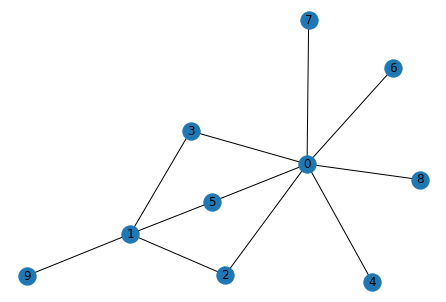

In [4]:
# env = graphRL(network_size=10, edge_prob=0.1, percent_mal=0.4, attack_probs=[0.3, 0.8])
env = graphRL('./env/env1.txt')

for a in env.devices:
    if a.mal:
        print(f'Node {a.node} IS malicious. Attack probability is {a.attack_prob:.2f}.')
    else:
        print(f'Node {a.node} is NOT malicious.')
        
env.render()

Some hyperparameters we introduce when we move to a RL environment:
* `corrupted_path_penalty` refers to the penalty our algorithm incurs when it takes a path that is corrupted. Setting this value is a choice; in this cell, we have made it equal to `env.network_size`, which means that a corrupted path is as bad or worse than the longest path in the network.
* `dead_end_penalty` refers to the penalty our algorithm incurs when it encounters a dead-end node. We don't need to consider this node for future pathfinding, so we put a high penalty on it. When we encounter a dead-end node, we don't ever want to visit it again. For this reason, we need to make the `dead_end_penalty` higher than any total penalty that could be incurred along a single path (since our Q-table keeps track of the **average** penalty for each node). The highest penalty would be a corrupted path that uses every single node in the network (`env.network_size + corrupted_path_penalty`). We multiply this by 2 just so the dead end nodes stand out more in the Q-table.
* `training_iterations` refers to the number of times we will try to find a path from the source to the destination. Too few iterations will lead to underfitting; too many will lead to overfitting.

The other hyperparameters are used for the Q-learning algorithm (definitions used from the [RL tutorial source](https://www.learndatasci.com/tutorials/reinforcement-q-learning-scratch-python-openai-gym/)):
* `alpha` is the learning rate (0 < $\alpha$ <= 1). This captures the extent to which the Q-values are updated from one training iteration.
* `gamma` is the discount factor (0 < $\gamma$ <= 1). $\gamma$ determines how much importance we want to give to future rewards. A lower $\gamma$ makes our algorithm consider immediate rewards more, while a higher $\gamma$ captures a long-term effective reward.
* `epsilon` is the degree (0 < $\epsilon$ <= 1) to which we want to explore the action space (i.e. pick a random value) or exploit our learned Q-values. A lower $\epsilon$ will result in more penalties during training because we are more often picking new, unexplored paths. A higher $\epsilon$ will result in fewer penalties during training but may lead to overfitting.

In [5]:
training_iterations = 1000
corrupted_path_penalty = env.network_size
dead_end_penalty = 2 * (env.network_size + corrupted_path_penalty)

alpha = 0.1
gamma = 0.6
epsilon = 0.1

Initialize the Q table. Additionally, go through and find all of the nodes that don't connect to each other. Set these to -infinity, so we do not select these actions when training. Since our algorithm does not find cyclic paths (using the same node twice) and always ends when it reaches the destination, we will also set any pairs ending in the source or beginning with the destination to -infinity. The algorithm will never touch these values anyway, but it makes for a more clear Q-table.

In [6]:
q_table = np.zeros([env.num_states, env.num_actions])

for state in range(0, len(q_table)):
    possible_actions = list(range(0, len(q_table)))
    
    valid_neighbors = list(env.graph.neighbors(state))
    
    for action in possible_actions:
        action = int(action)
        if action not in valid_neighbors:
            q_table[state][action] = -np.Inf
       
q_table[:, env.src] = -np.Inf
q_table[env.dst, :] = -np.Inf
            
print(q_table)

[[-inf -inf   0.   0.   0.   0.   0.   0.   0. -inf]
 [-inf -inf   0.   0. -inf   0. -inf -inf -inf   0.]
 [-inf   0. -inf -inf -inf -inf -inf -inf -inf -inf]
 [-inf   0. -inf -inf -inf -inf -inf -inf -inf -inf]
 [-inf -inf -inf -inf -inf -inf -inf -inf -inf -inf]
 [-inf   0. -inf -inf -inf -inf -inf -inf -inf -inf]
 [-inf -inf -inf -inf -inf -inf -inf -inf -inf -inf]
 [-inf -inf -inf -inf -inf -inf -inf -inf -inf -inf]
 [-inf -inf -inf -inf -inf -inf -inf -inf -inf -inf]
 [-inf -inf -inf -inf -inf -inf -inf -inf -inf -inf]]


Train the algorithm. Some notes about this cell, because it is the most complicated cell in the notebook:
* We are trying to find paths from the source to the destination, and we go one node at a time. Think of the current state as the node we are currently at. The possible actions we can choose from are the other nodes that we can visit from this node (so, its neighbors). However, this is at odds with how we define the Q-table, where all actions are technically "valid" from each state. For this reason, we keep a `valid_neighbors` array to reference when we select an action. If a node is a dead end, it will have no valid neighbors and we can stop the training iteration. 
* When we are finding paths from the source to the destination, we don't want to visit the same node twice (this is called a cycle and can easily lead to infinite loops). We use the `VISITED` flag and `visit_arr` to mark whether we've visited a node in the current pathfinding iteration. This also helps us when we look at the `valid_neighbors` of a node. 

In [7]:
VISITED = -1
times_visited = np.zeros([env.num_states, env.num_actions])

# For plotting metrics
all_epochs = []
all_penalties = []

# Number of training iterations
for i in range(1, training_iterations+1):
    total_penalty = 0
    path = []
    
    state = env.src
    prev_state = env.src # Use previous state to help keep track of dead ends
    
    done = False
    
    visit_arr = np.zeros(env.network_size)
    
    while not done:
        path.append(state)
        dead_end = True
        visit_arr[state] = VISITED # Shows that we have visited a node
        
        valid_neighbors = list(env.graph.neighbors(state)) # These are the valid possible actions
        
        # Check to see if the node is a dead end (if there are any valid neighbors, they have been visited already)
        for neighbor in valid_neighbors:
            if visit_arr[neighbor] != VISITED:
                dead_end = False
        
        # This node is a dead end, so we put a giant penalty on it so we don't go to it again in future iterations
        if dead_end:
            q_table[prev_state, state] = -dead_end_penalty 
            done = True

        # The node is not a dead end, so we continue trying to find paths to the destination
        else:  
            # Explore the action space by picking a random action
            if random.uniform(0, 1) < epsilon:
                action = env.action_space.sample()
                
                # Make sure the action is valid by referencing the valid neighbors and visited arrays
                while action not in valid_neighbors or visit_arr[action] == VISITED:
                    action = env.action_space.sample()
            
            # Exploit learned values by selecting the best action from the current state based on our Q-table
            else:
                slc = q_table[state]
                action = np.argmax(slc)               

                # Make sure the action is valid by referencing the valid neighbors and visited arrays
                while action not in valid_neighbors or visit_arr[action] == VISITED:
                    slc[action] = -np.Inf # Doing this helps prevent backtracking
                    action = np.argmax(slc)                    
    
            # Now, we've finally selected an action. 
            # We can take the step and update the Q-table according to the algorithm.            
            next_state = action
            prev_state = state
            state = next_state

            if state == env.dst:
                path.append(state)
                done = True
                
            total_penalty += 1
    
    # Print out the path we took.
    # If we got to the destination, determine if that path was corrupted. Update the reward accordingly    
    if dead_end == True:
        print(f'Path taken = {path}. Encountered a dead end.')
    else:               
        if env.is_corrupted(path):
            # The path is corrupted, but our algorithm doesn't know what node is the cause. 
            # So, we penalize all of the nodes. Over time, the nodes that are actually corrupted will be
            # penalized more often than the nodes that aren't.
            total_penalty += corrupted_path_penalty
            print(f'Path taken = {path}. This path was corrupted.')
            
        print(f'Path taken = {path}.')
        
        # The path[0:len(path)-2] is a way of not penalizing the links that end in the destination node.
        # We want to update the Q table, but we want to keep it normalized relative to the dead end penalty.
        # So, we keep track of how many times we've encountered a (state, action) pair and keep track of the
        # average penalty incurred when going that way.
        for state in path[0:len(path)-2]:
            action = path[path.index(state)+1]
            visits = times_visited[state, action]
            if visits == 0:
                q_table[state, action] -= total_penalty
                
            else:
                avg_penalty = (q_table[state, action] * visits - total_penalty) / (visits + 1)
                q_table[state, action] = avg_penalty
                
            times_visited[state, action] += 1
            
    all_epochs.append(i)
    all_penalties.append(total_penalty)

Path taken = [0, 2, 1, 3]. Encountered a dead end.
Path taken = [0, 2, 1, 5]. Encountered a dead end.
Path taken = [0, 7]. Encountered a dead end.
Path taken = [0, 2, 1, 9].
Path taken = [0, 3, 1, 9]. This path was corrupted.
Path taken = [0, 3, 1, 9].
Path taken = [0, 4]. Encountered a dead end.
Path taken = [0, 5, 1, 9]. This path was corrupted.
Path taken = [0, 5, 1, 9].
Path taken = [0, 6]. Encountered a dead end.
Path taken = [0, 8]. Encountered a dead end.
Path taken = [0, 2, 1, 9].
Path taken = [0, 3, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 5, 1, 9]. This path was corrupted.
Path taken = [0, 5, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1,

Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 8]. Encountered a dead end.
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 5]. Encountered a dead end.
Path taken = [0, 4]. Encountered a dead end.
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1,

Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 5]. Encountered a dead end.
Path taken = [0, 3, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 5]. Encountered a dead end.
Path taken = [0, 3, 1, 9]. This path was corrupted.
Path taken = [0, 3, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path take

## 3. Results
Now that the training is finished, we can print out the Q table and try to visually confirm that our algorithm has learned the optimal paths. The rows represent the current state, and the columns represent the possible actions from that state. 

For each node, we would like to understand how 'trustworthy' it is when finding paths from the source to the destination. Each column reflects all of the paths that can involve an individual node. Even if a node is not malicious, it will be punished when it is involved in a corrupted or dead end path. Therefore, we compute the trustworthiness of each node by taking the maximum of each column of the Q table.

In [12]:
# For reference when reading the Q table
print(f'Corrupted path penalty is {corrupted_path_penalty}.')
print(f'Dead end penalty is {dead_end_penalty}.')

q_table_df = pd.DataFrame(q_table)
trust_df = q_table_df.max(axis='rows')

print('\n')
print(q_table_df)
print('\n')
print(trust_df)

Corrupted path penalty is 10.
Dead end penalty is 40.


     0          1    2     3     4          5     6     7     8    9
0 -inf       -inf -3.0  -8.0 -40.0 -12.285714 -40.0 -40.0 -40.0 -inf
1 -inf       -inf -inf -40.0  -inf -40.000000  -inf  -inf  -inf  0.0
2 -inf  -3.000000 -inf  -inf  -inf       -inf  -inf  -inf  -inf -inf
3 -inf  -8.000000 -inf  -inf  -inf       -inf  -inf  -inf  -inf -inf
4 -inf       -inf -inf  -inf  -inf       -inf  -inf  -inf  -inf -inf
5 -inf -12.285714 -inf  -inf  -inf       -inf  -inf  -inf  -inf -inf
6 -inf       -inf -inf  -inf  -inf       -inf  -inf  -inf  -inf -inf
7 -inf       -inf -inf  -inf  -inf       -inf  -inf  -inf  -inf -inf
8 -inf       -inf -inf  -inf  -inf       -inf  -inf  -inf  -inf -inf
9 -inf       -inf -inf  -inf  -inf       -inf  -inf  -inf  -inf -inf


0         -inf
1    -3.000000
2    -3.000000
3    -8.000000
4   -40.000000
5   -12.285714
6   -40.000000
7   -40.000000
8   -40.000000
9     0.000000
dtype: float64


We can also do a more formal verification of the results. This code uses some of our training code to rerun the algorithm and find what it has determined to be the most efficient, safest paths through the graph.

In [9]:
total_hops, total_penalties = 0, 0
episodes = 100

for _ in range(episodes):
    path = []
    hops, penalties = 0, 0
    state = env.src
    visit_arr = np.zeros(env.network_size)
        
    done = False
    
    while not done:
        hops += 1
        path.append(state)
        dead_end = True
        visit_arr[state] = VISITED
        
        valid_neighbors = list(env.graph.neighbors(state))

        for neighbor in valid_neighbors:
            if visit_arr[neighbor] != VISITED:
                dead_end = False

        if dead_end:
            total_penalties += 1
            done = True
        
        else:
            action = np.argmax(q_table[state])
            state = action
        
        if state == env.dst:
            done = True
        
    if env.is_corrupted(path):
        total_penalties += 1
    
    path.append(env.dst)
    total_hops += hops
    
print(f"Results after {episodes} episodes:")
print(f"Average hops per episode: {total_hops / episodes}")
print(f"Average penalties per episode: {total_penalties / episodes}")

Results after 100 episodes:
Average hops per episode: 3.0
Average penalties per episode: 0.0
